In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

from torch.utils.data import Dataset, DataLoader, BatchSampler, random_split
from torchvision import transforms
from PIL import Image

In [3]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train_images/283.jpg  
  inflating: __MACOSX/data/train_images/._283.jpg  
  inflating: data/train_images/4647.jpg  
  inflating: __MACOSX/data/train_images/._4647.jpg  
  inflating: data/train_images/3128.jpg  
  inflating: __MACOSX/data/train_images/._3128.jpg  
  inflating: data/train_images/2236.jpg  
  inflating: __MACOSX/data/train_images/._2236.jpg  
  inflating: data/train_images/5559.jpg  
  inflating: __MACOSX/data/train_images/._5559.jpg  
  inflating: data/train_images/6050.jpg  
  inflating: __MACOSX/data/train_images/._6050.jpg  
  inflating: data/train_images/1059.jpg  
  inflating: __MACOSX/data/train_images/._1059.jpg  
  inflating: data/train_images/3896.jpg  
  inflating: __MACOSX/data/train_images/._3896.jpg  
  inflating: data/train_images/2550.jpg  
  inflating: __MACOSX/data/train_images/._2550.jpg  
  inflating: data/train_images/4121.jpg  
  inflating: __MACOSX/data/train_images/._4121.jpg  
 

# Dataset class and loading

In [8]:
# Create Dataset class for multilabel classification
class MultiClassImageDataset(Dataset):
    def __init__(self, ann_df, super_map_df, sub_map_df, img_dir, transform=None):
        self.ann_df = ann_df
        self.super_map_df = super_map_df
        self.sub_map_df = sub_map_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.ann_df)

    def __getitem__(self, idx):
        img_name = self.ann_df['image'][idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        super_idx = self.ann_df['superclass_index'][idx]
        super_label = self.super_map_df['class'][super_idx]

        sub_idx = self.ann_df['subclass_index'][idx]
        sub_label = self.sub_map_df['class'][sub_idx]

        if self.transform:
            image = self.transform(image)

        return image, super_idx, super_label, sub_idx, sub_label

class MultiClassImageTestDataset(Dataset):
    def __init__(self, super_map_df, sub_map_df, img_dir, transform=None):
        self.super_map_df = super_map_df
        self.sub_map_df = sub_map_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self): # Count files in img_dir
        return len([fname for fname in os.listdir(self.img_dir)])

    def __getitem__(self, idx):
        img_name = str(idx) + '.jpg'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name

In [9]:
train_ann_df = pd.read_csv('data/train_data.csv')
# test_ann_df = pd.read_csv('data/test_data.csv')
super_map_df = pd.read_csv('data/superclass_mapping.csv')
sub_map_df = pd.read_csv('data/subclass_mapping.csv')

train_img_dir = 'data/train_images'
test_img_dir = 'data/test_images'

image_preprocessing = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create train and val split
train_dataset = MultiClassImageDataset(train_ann_df, super_map_df, sub_map_df, train_img_dir, transform=image_preprocessing)
train_dataset, val_dataset = random_split(train_dataset, [0.9, 0.1])

# Create test dataset
test_dataset = MultiClassImageTestDataset(super_map_df, sub_map_df, test_img_dir, transform=image_preprocessing)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=1,
                         shuffle=False)

# Model class

In [10]:
class EfficientNetV2MultiHead(nn.Module):
    def __init__(self, num_super=4, num_sub=88, pretrained=True):
        super().__init__()
        weights = EfficientNet_V2_S_Weights.DEFAULT if pretrained else None
        pre_trained = efficientnet_v2_s(weights=weights)
        self.backbone = pre_trained.features
        self.avgpool = pre_trained.avgpool
        self.fc = nn.Linear(1280, 256)
        self.dropout = nn.Dropout(0.3)
        self.classifer_super = nn.Linear(256, num_super)
        self.classifer_sub = nn.Linear(256 + num_super, num_sub)

    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc(x))
        x = self.dropout(x)
        # print(x.size())
        super_out = self.classifer_super(x)
        # print(super_out)

        super_probs = F.softmax(super_out, dim=1)
        x_with_super = torch.cat([x, super_probs], dim=1)

        sub_out = self.classifer_sub(x_with_super)
        return super_out, sub_out

class Trainer():
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, test_loader=None, device='cuda'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_superclass_acc': [],
            'val_subclass_acc': []
        }

    def train_epoch(self):
        running_loss = 0.0
        for i, data in enumerate(self.train_loader):
            inputs, super_labels, sub_labels = data[0].to(device), data[1].to(device), data[3].to(device)

            self.optimizer.zero_grad()
            super_outputs, sub_outputs = self.model(inputs)
            loss = self.criterion(super_outputs, super_labels) + self.criterion(sub_outputs, sub_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Training loss: {running_loss/i:.3f}')

        avg_loss = running_loss/i
        self.history['train_loss'].append(avg_loss)

    def validate_epoch(self):
        super_correct = 0
        sub_correct = 0
        total = 0
        running_loss = 0.0

        with torch.no_grad():
            for i, data in enumerate(self.val_loader):
                inputs, super_labels, sub_labels = data[0].to(device), data[1].to(device), data[3].to(device)

                super_outputs, sub_outputs = self.model(inputs)
                loss = self.criterion(super_outputs, super_labels) + self.criterion(sub_outputs, sub_labels)
                _, super_predicted = torch.max(super_outputs.data, 1)
                _, sub_predicted = torch.max(sub_outputs.data, 1)

                total += super_labels.size(0)
                super_correct += (super_predicted == super_labels).sum().item()
                sub_correct += (sub_predicted == sub_labels).sum().item()
                running_loss += loss.item()

        print(f'Validation loss: {running_loss/i:.3f}')
        print(f'Validation superclass acc: {100 * super_correct / total:.2f} %')
        print(f'Validation subclass acc: {100 * sub_correct / total:.2f} %')

        avg_loss = running_loss/i
        superclass_acc = 100*super_correct/total
        subclass_acc = 100*sub_correct/total
        self.history['val_loss'].append(avg_loss)
        self.history['val_superclass_acc'].append(superclass_acc)
        self.history['val_subclass_acc'].append(subclass_acc)


    def test(self, save_to_csv=False, return_predictions=False):
        if not self.test_loader:
            raise NotImplementedError('test_loader not specified')

        # Evaluate on test set, in this simple demo no special care is taken for novel/unseen classes
        test_predictions = {'image': [], 'superclass_index': [], 'subclass_index': []}
        with torch.no_grad():
            for i, data in enumerate(self.test_loader):
                inputs, img_name = data[0].to(device), data[1]

                super_outputs, sub_outputs = self.model(inputs)
                _, super_predicted = torch.max(super_outputs.data, 1)
                _, sub_predicted = torch.max(sub_outputs.data, 1)

                test_predictions['image'].append(img_name[0])
                test_predictions['superclass_index'].append(super_predicted.item())
                test_predictions['subclass_index'].append(sub_predicted.item())

        test_predictions = pd.DataFrame(data=test_predictions)

        if save_to_csv:
            test_predictions.to_csv('example_test_predictions.csv', index=False)

        if return_predictions:
            return test_predictions

    def plot_history(self, save=False):
      epochs = range(1, len(self.history['train_loss'])+1)
      plt.figure(figsize=(12, 5))

      # train/val loss plot
      plt.subplot(1, 2, 1)
      plt.plot(epochs, self.history['train_loss'], label='Train')
      plt.plot(epochs, self.history['val_loss'], label='Val')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Loss per Epoch')
      plt.legend()

      # super/sub-class accuracy plot
      plt.subplot(1, 2, 2)
      plt.plot(epochs, self.history['val_superclass_acc'], label='Superclass')
      plt.plot(epochs, self.history['val_subclass_acc'], label='Subclass')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy (%)')
      plt.title('Validation Accuracy per Epoch')
      plt.legend()

      plt.tight_layout()

      if save:
        plt.savefig('training-history.png')

      plt.show()

# Model visualization

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [12]:
# example usage: predict(model, train_dataset)
def predict(model, dataset):
  data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

  predictions = {
    'image': [],
    'true_superclass': [],
    'pred_superclass': [],
    'true_subclass': [],
    'pred_subclass': []
  }
  super_correct = {}
  super_total = {}
  sub_correct = {}
  sub_total = {}
  sub_correct_per_super = {}
  sub_total_per_super = {}

  with torch.no_grad():
    for i, data in enumerate(data_loader):
      # getting class indices not class names here btw
      input, super_label, sub_label, = data[0].to(device), data[1], data[3]
      super_output, sub_output = model(input)
      _, super_predicted = torch.max(super_output.data, 1)
      _, sub_predicted = torch.max(sub_output.data, 1)

      # some processing bc these are tensor objects, and of batch size 1
      img_name = super_label[0].item()
      super_label = super_label[0].item()
      super_predicted = super_predicted[0].item()
      sub_label = sub_label[0].item()
      sub_predicted = sub_predicted[0].item()

      # record each image's true and predicted labels
      predictions['image'].append(img_name)
      predictions['true_superclass'].append(super_label)
      predictions['pred_superclass'].append(super_predicted)
      predictions['true_subclass'].append(sub_label)
      predictions['pred_subclass'].append(sub_predicted)

      # count correct super class predictions
      super_correct[super_label] = super_correct.get(super_label, 0) + (super_predicted == super_label)
      super_total[super_label] = super_total.get(super_label, 0) + 1

      # count correct sub class predictions
      sub_correct[sub_label] = sub_correct.get(sub_label, 0) + (sub_predicted == sub_label)
      sub_total[sub_label] = sub_total.get(sub_label, 0) + 1

      # count correct sub class predictions for each superclass
      sub_correct_per_super[super_label] = sub_correct_per_super.get(super_label, 0) + (sub_predicted == sub_label)
      sub_total_per_super[super_label] = sub_total_per_super.get(super_label, 0) + 1

  # convert to dataframe
  predictions = pd.DataFrame(predictions)
  return predictions, super_correct, super_total, sub_correct, sub_total, sub_correct_per_super, sub_total_per_super

def plot_subclass_confusion_matrix(predictions, save=False):
  '''Expects predictions to be dataframe generated from predict method above'''
  cm = confusion_matrix(predictions['true_subclass'], predictions['pred_subclass'])
  plt.figure(figsize=(12, 10))
  sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
  plt.title('Subclass Confusion Matrix')
  plt.xlabel('Predicted Subclass')
  plt.ylabel('True Subclass')

  if save:
    plt.savefig('subclass-confusion-matrix.png')

  plt.show()

def plot_class_accuracy(correct, total, map_df, class_type, title, include_names=False, save=False):
  '''Expects correct, total to be dictionaries generated from predict method above.
  map_df should be a dataframe mapping indices to names for that class_type'''
  class_map = dict(zip(map_df['index'], map_df['class']))
  accuracy = {label: correct[label] / total[label] for label in total}

  x = [f"{class_map[label]} ({label})" for label in accuracy] if include_names else [label for label in accuracy]
  height = [accuracy[label] for label in accuracy]

  plt.figure(figsize=(10, 6))
  plt.bar(x, height)
  plt.xlabel(f"{class_type} Index") # expected class_type: Superclass, Subclass
  plt.ylabel('Accuracy')
  plt.title(title) # expected title: Accuracy per Superclass, Accuracy per Subclass, Accuracy of Subclass per Superclass
  plt.xticks(rotation=45)
  plt.tight_layout()

  if save:
    plt.savefig(title + '.png')

  plt.show()

# Model training (original)

In [13]:
# Init model and trainer
device = 'cuda' # 'cpu'
num_super_classes = 4
num_super_classes = 88
model = EfficientNetV2MultiHead(num_super=num_super_classes, num_sub=num_super_classes, pretrained=True).to(device)
for param in model.backbone.parameters():
    param.requires_grad = False
last_blocks = list(model.backbone)[-1:]  # Unfreeze last 3 blocks
for block in last_blocks:
    for param in block.parameters():
        param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, test_loader)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 198MB/s]


In [14]:
torch.cuda.empty_cache()

In [15]:
# Training loop
for epoch in range(20):
    print(f'Epoch {epoch+1}')
    trainer.train_epoch()
    trainer.validate_epoch()
    print('')

print('Finished Training')

Epoch 1
Training loss: 3.096
Validation loss: 1.628
Validation superclass acc: 97.93 %
Validation subclass acc: 57.01 %

Epoch 2
Training loss: 1.283
Validation loss: 1.141
Validation superclass acc: 96.18 %
Validation subclass acc: 67.20 %

Epoch 3
Training loss: 0.852
Validation loss: 0.964
Validation superclass acc: 97.77 %
Validation subclass acc: 72.29 %

Epoch 4
Training loss: 0.691
Validation loss: 0.905
Validation superclass acc: 97.13 %
Validation subclass acc: 74.20 %

Epoch 5
Training loss: 0.586
Validation loss: 0.796
Validation superclass acc: 98.09 %
Validation subclass acc: 76.91 %

Epoch 6
Training loss: 0.511
Validation loss: 0.875
Validation superclass acc: 97.61 %
Validation subclass acc: 75.32 %

Epoch 7
Training loss: 0.452
Validation loss: 0.758
Validation superclass acc: 98.25 %
Validation subclass acc: 79.78 %

Epoch 8
Training loss: 0.409
Validation loss: 0.767
Validation superclass acc: 98.89 %
Validation subclass acc: 75.64 %

Epoch 9
Training loss: 0.387
Val

# Model training with augmented data

In [16]:
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy

augmentation_setups = {
    "baseline": transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
    "autoaugment": transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
    "manual_combo": transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
}

In [17]:
results = []

for name, transform in augmentation_setups.items():
    print(f"\n Training with: {name.upper()}")

    # Create datasets with the current transform
    train_dataset = MultiClassImageDataset(train_ann_df, super_map_df, sub_map_df, train_img_dir, transform=transform)
    train_dataset, val_dataset = random_split(train_dataset, [0.9, 0.1])
    test_dataset = MultiClassImageTestDataset(super_map_df, sub_map_df, test_img_dir, transform=transform)

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Re-init model
    model = EfficientNetV2MultiHead(num_super=4, num_sub=88, pretrained=True).to(device)
    for param in model.backbone.parameters():
        param.requires_grad = False
    for block in list(model.backbone)[-1:]:
        for param in block.parameters():
            param.requires_grad = True

    # Set up training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, test_loader)

    # Run training loop
    for epoch in range(5):
        trainer.train_epoch()
        trainer.validate_epoch()

    # Save results
    results.append({
        "setup": name,
        "val_superclass_acc": trainer.history['val_superclass_acc'][-1],
        "val_subclass_acc": trainer.history['val_subclass_acc'][-1],
        "val_loss": trainer.history['val_loss'][-1]
    })



🔁 Training with: BASELINE
Training loss: 2.716
Validation loss: 1.705
Validation superclass acc: 96.50 %
Validation subclass acc: 52.71 %
Training loss: 1.152
Validation loss: 1.056
Validation superclass acc: 97.77 %
Validation subclass acc: 66.88 %
Training loss: 0.802
Validation loss: 0.931
Validation superclass acc: 96.97 %
Validation subclass acc: 72.77 %
Training loss: 0.658
Validation loss: 0.880
Validation superclass acc: 98.25 %
Validation subclass acc: 71.97 %
Training loss: 0.538
Validation loss: 0.779
Validation superclass acc: 98.57 %
Validation subclass acc: 76.43 %

🔁 Training with: AUTOAUGMENT
Training loss: 3.336
Validation loss: 2.371
Validation superclass acc: 93.47 %
Validation subclass acc: 41.56 %
Training loss: 1.887
Validation loss: 1.847
Validation superclass acc: 95.06 %
Validation subclass acc: 50.32 %
Training loss: 1.547
Validation loss: 1.654
Validation superclass acc: 95.38 %
Validation subclass acc: 57.32 %
Training loss: 1.369
Validation loss: 1.510
Val

In [18]:
df_results = pd.DataFrame(results)
print(df_results)

df_results.to_csv("augmentation_results.csv", index=False)

          setup  val_superclass_acc  val_subclass_acc  val_loss
0      baseline           98.566879         76.433121  0.779496
1   autoaugment           95.541401         62.101911  1.371266
2  manual_combo           98.566879         73.566879  0.888745


In [ ]:
# added augmentation --> AutoAugment
image_preprocessing = transforms.Compose([
    transforms.Resize((384, 384)),

    # transforms.RandomHorizontalFlip(p=0.5), # flip horizontally
    # transforms.RandomRotation(degrees=15), # slight random rotation
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # slight translation
    # transforms.RandomGrayscale(p=0.1), # convert some to grayscale
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)), # slight blurring
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # color augmentation

    transforms.AutoAugment(policy=AutoAugmentPolicy.IMAGENET), # predefined policy from imagenet

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_ann_df = pd.read_csv('data/train_data.csv')
# test_ann_df = pd.read_csv('data/test_data.csv')
super_map_df = pd.read_csv('data/superclass_mapping.csv')
sub_map_df = pd.read_csv('data/subclass_mapping.csv')

train_img_dir = 'data/train_images'
test_img_dir = 'data/test_images'


# # Create train and val split
# train_dataset = MultiClassImageDataset(train_ann_df, super_map_df, sub_map_df, train_img_dir, transform=image_preprocessing)
# train_dataset, val_dataset = random_split(train_dataset, [0.9, 0.1])

# # Create test dataset
# test_dataset = MultiClassImageTestDataset(super_map_df, sub_map_df, test_img_dir, transform=image_preprocessing)

# ==== Modified version of above in order to be able to test =====
train_dataset = MultiClassImageDataset(train_ann_df, super_map_df, sub_map_df, train_img_dir, transform=image_preprocessing)
train_dataset, val_dataset, test_dataset = random_split(train_dataset, [0.7, 0.1, 0.2])
# test_dataset = MultiClassImageTestDataset(super_map_df, sub_map_df, test_img_dir, transform=image_preprocessing)


# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# Init model and trainer
device = 'cuda' # 'cpu'
num_super_classes = 4
num_super_classes = 88
model = EfficientNetV2MultiHead(num_super=num_super_classes, num_sub=num_super_classes, pretrained=True).to(device)
for param in model.backbone.parameters():
    param.requires_grad = False
last_blocks = list(model.backbone)[-1:]  # Unfreeze last 3 blocks
for block in last_blocks:
    for param in block.parameters():
        param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, test_loader)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Training loop
for epoch in range(20):
    print(f'Epoch {epoch+1}')
    trainer.train_epoch()
    trainer.validate_epoch()

print('Finished Training')

Epoch 1
Training loss: 3.959
Validation loss: 2.877
Validation superclass acc: 92.53 %
Validation subclass acc: 31.96 %
Epoch 2
Training loss: 2.265
Validation loss: 2.032
Validation superclass acc: 93.80 %
Validation subclass acc: 50.72 %
Epoch 3
Training loss: 1.761
Validation loss: 1.668
Validation superclass acc: 95.07 %
Validation subclass acc: 56.12 %
Epoch 4
Training loss: 1.507
Validation loss: 1.606
Validation superclass acc: 94.44 %
Validation subclass acc: 57.07 %
Epoch 5
Training loss: 1.386
Validation loss: 1.454
Validation superclass acc: 96.50 %
Validation subclass acc: 62.00 %
Epoch 6
Training loss: 1.281
Validation loss: 1.344
Validation superclass acc: 97.30 %
Validation subclass acc: 65.02 %
Epoch 7
Training loss: 1.155
Validation loss: 1.464
Validation superclass acc: 96.03 %
Validation subclass acc: 62.00 %
Epoch 8
Training loss: 1.145
Validation loss: 1.350
Validation superclass acc: 96.34 %
Validation subclass acc: 62.80 %
Epoch 9
Training loss: 1.100
Validation 

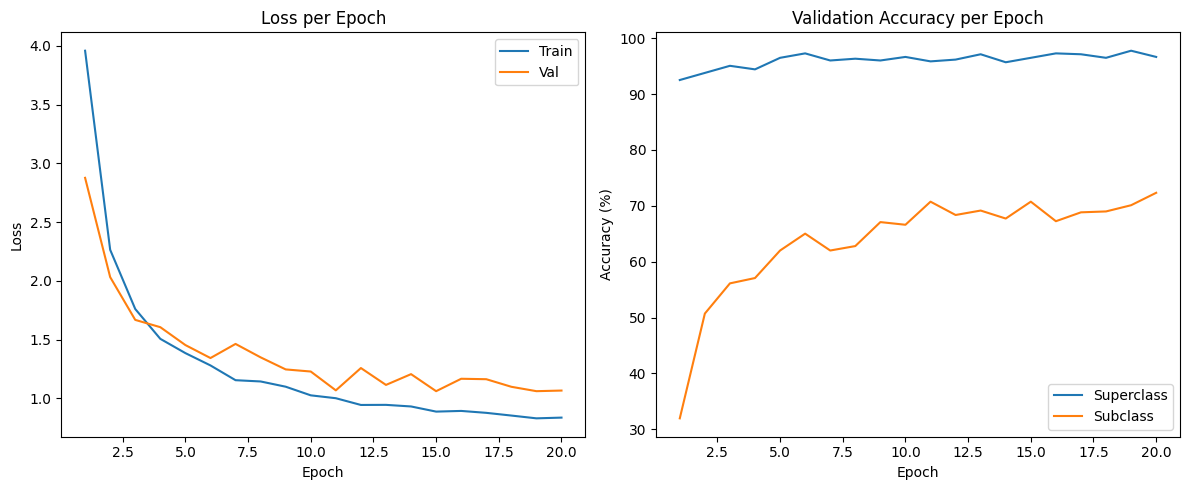

In [ ]:
trainer.plot_history(save=True)

## test model

In [ ]:
predictions, super_correct, super_total, sub_correct, sub_total, sub_correct_per_super, sub_total_per_super = predict(model, test_dataset)

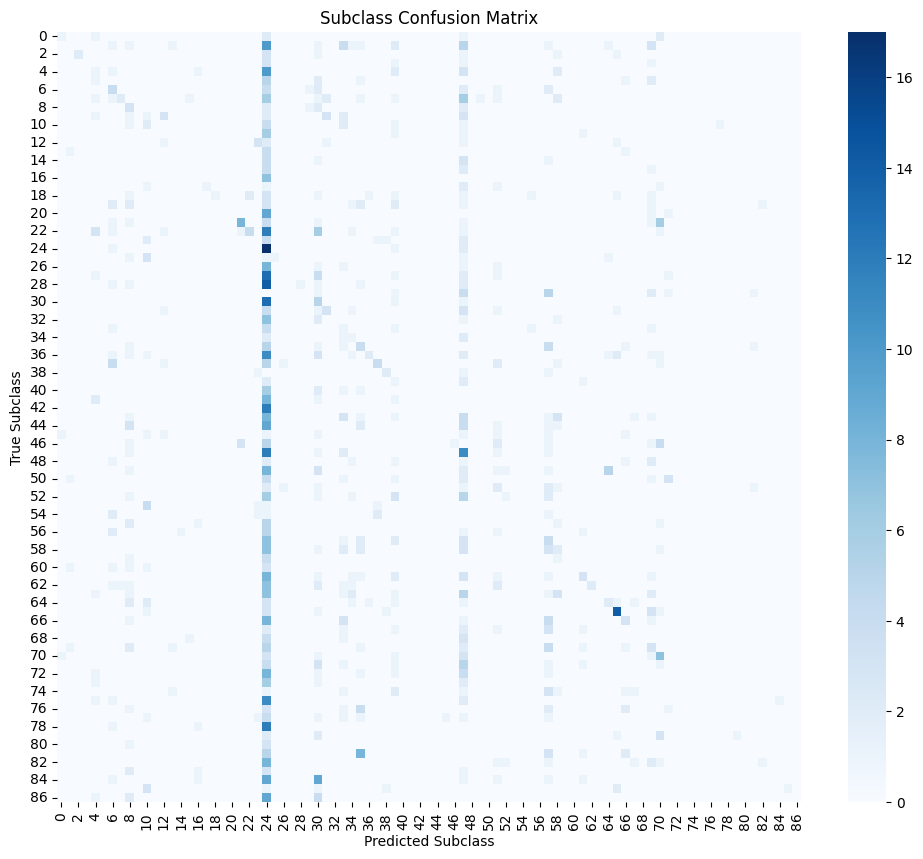

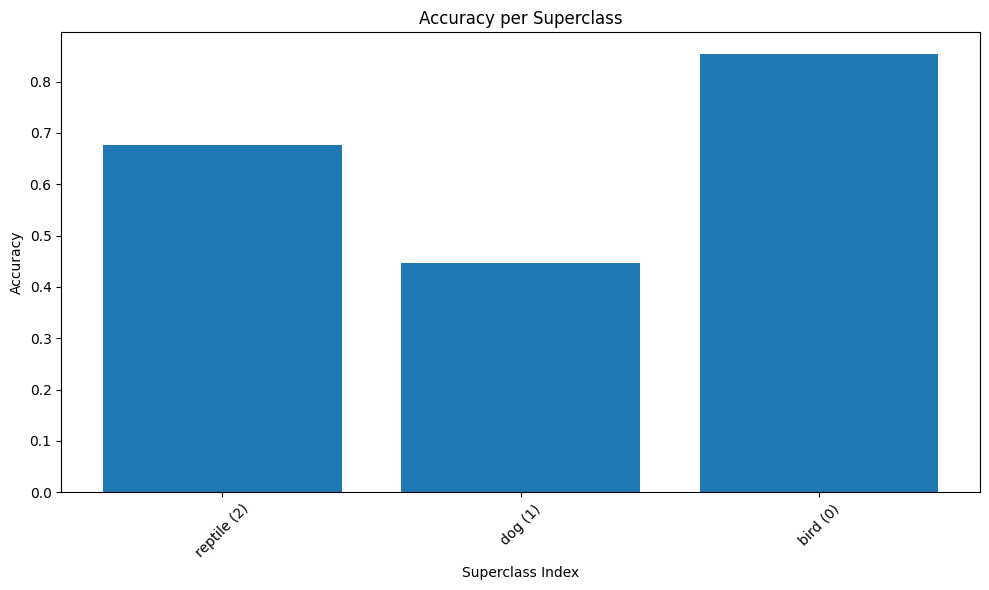

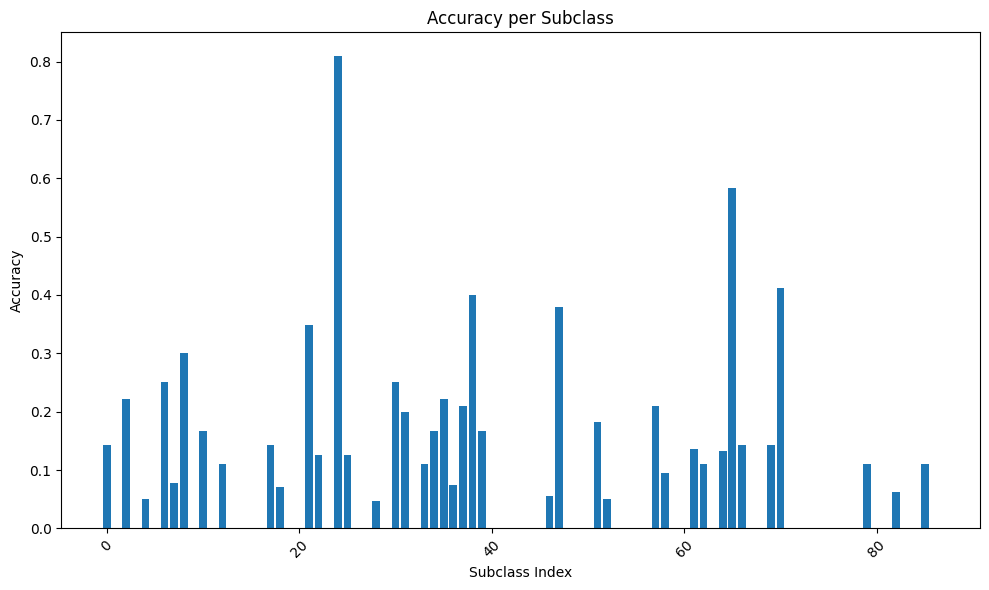

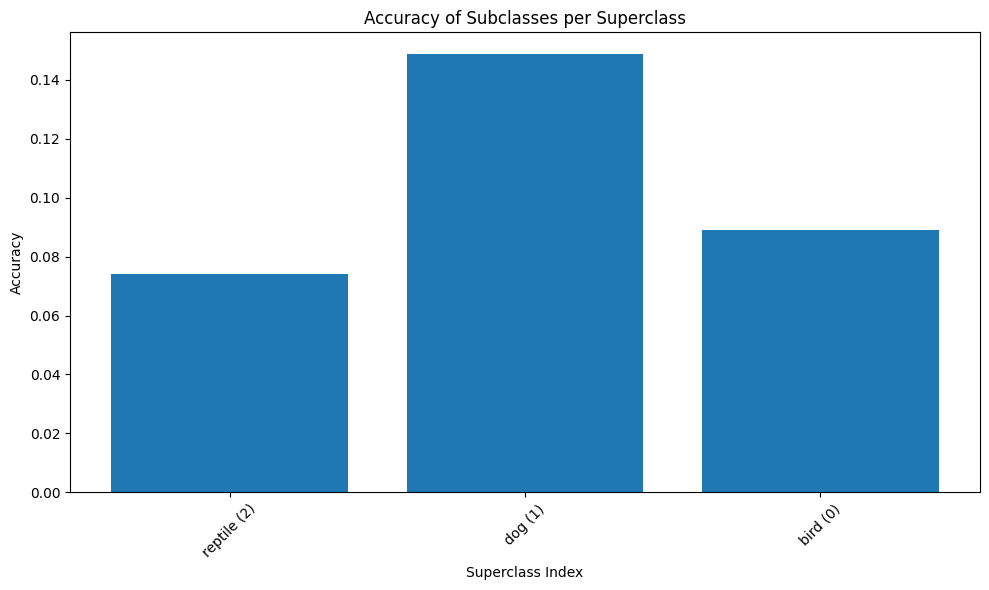

In [ ]:
save = True

plot_subclass_confusion_matrix(predictions, save=save)
plot_class_accuracy(super_correct, super_total, super_map_df, 'Superclass', 'Accuracy per Superclass', include_names=True, save=save)
plot_class_accuracy(sub_correct, sub_total, sub_map_df, 'Subclass', 'Accuracy per Subclass', save=save)
plot_class_accuracy(sub_correct_per_super, super_total, super_map_df, 'Superclass', 'Accuracy of Subclasses per Superclass', include_names=True, save=save)

# Predict and evaluate on test data

In [ ]:
test_predictions = trainer.test(save_to_csv=True, return_predictions=True)

In [ ]:
# Quick script for evaluating generated csv files with ground truth

super_correct = 0
sub_correct = 0
seen_super_correct = 0
seen_sub_correct = 0
unseen_super_correct = 0
unseen_sub_correct = 0

total = 0
seen_super_total = 0
unseen_super_total = 0
seen_sub_total = 0
unseen_sub_total = 0

for i in range(len(test_predictions)):
    super_pred = test_predictions['superclass_index'][i]
    sub_pred = test_predictions['subclass_index'][i]

    super_gt = test_ann_df['superclass_index'][i]
    sub_gt = test_ann_df['subclass_index'][i]

    # Total setting
    if super_pred == super_gt:
        super_correct += 1
    if sub_pred == sub_gt:
        sub_correct += 1
    total += 1

    # Unseen superclass setting
    if super_gt == 3:
        if super_pred == super_gt:
            unseen_super_correct += 1
        if sub_pred == sub_gt:
            unseen_sub_correct += 1
        unseen_super_total += 1
        unseen_sub_total += 1

    # Seen superclass, unseen subclass setting
    if super_gt != 3 and sub_gt == 87:
        if super_pred == super_gt:
            seen_super_correct += 1
        if sub_pred == sub_gt:
            unseen_sub_correct += 1
        seen_super_total += 1
        unseen_sub_total += 1

    # Seen superclass and subclass setting
    if super_gt != 3 and sub_gt != 87:
        if super_pred == super_gt:
            seen_super_correct += 1
        if sub_pred == sub_gt:
            seen_sub_correct += 1
        seen_super_total += 1
        seen_sub_total += 1

print('Superclass Accuracy')
print(f'Overall: {100*super_correct/total:.2f} %')
print(f'Seen: {100*seen_super_correct/seen_super_total:.2f} %')
print(f'Unseen: {100*unseen_super_correct/unseen_super_total:.2f} %')

print('\nSubclass Accuracy')
print(f'Overall: {100*sub_correct/total:.2f} %')
print(f'Seen: {100*seen_sub_correct/seen_sub_total:.2f} %')
print(f'Unseen: {100*unseen_sub_correct/unseen_sub_total:.2f} %')

Superclass Accuracy
Overall: 43.83 %
Seen: 61.11 %
Unseen: 0.00 %

Subclass Accuracy
Overall: 2.03 %
Seen: 9.56 %
Unseen: 0.00 %
